In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import shutil
from PIL import Image
import pydot
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.applications.imagenet_utils import preprocess_input

%matplotlib inline
warnings.filterwarnings('ignore')


Using TensorFlow backend.


# Data Engineering, Analysis, Pipeline

hey data !

where are you?
what do you look like?


In [2]:
# extract label from a file name
def extract_label(name_path):
    if "/" in name_path:
        seperator = '/'
    else:
        seperator = '\\'
    words = name_path.split(seperator)
    size = len(words) 
    if words:
        if ".checked" in words[size - 1].lower():
            return "checked", words[size - 1].lower(), 1, 1
        elif ".open" in words[size - 1].lower():
            return "open", words[size - 1].lower(), 1, 0
        elif ".not" in words[size - 1].lower():
            return "not", words[size - 1].lower(), 0, -1

    return "unknown", words[size - 1].lower()



In [3]:
# test
print(extract_label("./checkbox-data/dataset-mleng-exercise/editor-1/{00A64232-DEEF-27DF-D914-806388DB0660}.pdf.results/checkbox-01.open.png"))

('open', 'checkbox-01.open.png', 1, 0)


In [4]:
# collecting images and extracting labels

def collect_image_files(data_path, image_id):
        
    df = pd.DataFrame(columns=['path', 'image_id', 'name', 'label', 'is_checkbox', 'checked'])

    for root, dirs, files in os.walk(data_path): 
        for dir in dirs:
            if dir != "PaxHeader":
                path_dir = root + '/' + dir
                for r, subdir, files in os.walk(path_dir):
                    for file in files:
                        if "._" not in file and ".DS_Store" not in file:
                            path_file = path_dir + '/' + file
                            label, name, is_checkbox, checked = extract_label(path_file)
                            image_id += 1
                            df = df.append({'path':path_file , 'image_id': str(image_id), 'name':name ,'label':label, 'is_checkbox':is_checkbox, 'checked':checked}, ignore_index=True)

    print("collecting imgae files. Done!")
    return df, image_id


In [5]:
# It was assumed that data is provided by two different sources: editor-0 and editor-1
# imaged id is started from 0
# labels and metadata about images are recorded in a dataframe with following columns
# ['path', 'image_id', 'name', 'label', 'is_checkbox', 'checked']

input_path = "D:/Hassan/data/checkbox-data/dataset-mleng-exercise"

df1, number_of_file = collect_image_files(input_path + "/editor-0", 0)
df2, number_of_file = collect_image_files(input_path + "/editor-1", number_of_file)

df = pd.concat([df1, df2], axis=0)

collecting imgae files. Done!
collecting imgae files. Done!


                                                  path image_id  \
35   D:/Hassan/Data Analysis/Interview/Scienceclini...      595   
267  D:/Hassan/Data Analysis/Interview/Scienceclini...      827   
254  D:/Hassan/Data Analysis/Interview/Scienceclini...      814   

                        name    label is_checkbox checked  
35      checkbox-04.open.png     open           1       0  
267  checkbox-22.checked.png  checked           1       1  
254  checkbox-09.checked.png  checked           1       1  
number of images: 1427
number of not-a-checkbox: 427
number of checked-checkbox: 374
number of open-checkbox: 626


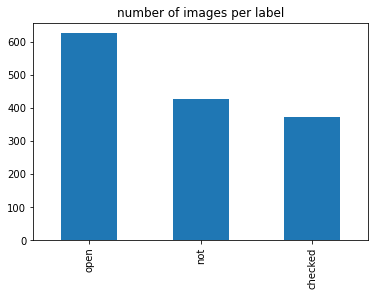

In [6]:
# Lets take a look into the dataset

print(df.sample(3))
df['label'].value_counts().plot(kind="bar", title= "number of images per label")
print("number of images: "  +  str(df.shape[0]))
print("number of not-a-checkbox: " + str(df[df['label']=="not"].shape[0]))
print("number of checked-checkbox: " + str( df[df['label']=="checked"].shape[0]))
print("number of open-checkbox: " + str(df[df['label']=="open"].shape[0]))

There are 427 not-a-checkbox and 1000 checkbox images. ----> ratio=2.3 ---> almost imbalanced

There are 374 checked-checkbox and 626 open-checkbox images ----> ratio=1.6 ---> almost imbalanced

In [7]:
# copy and rename images to working directory. file name turns into image id.

def copy_rename_file(row, work_dir, rename=True):
    shutil.copy2(row['path'], work_dir)
    if rename:
        os.rename(work_dir + '/' + row['name'], work_dir + '/' + row['image_id'] + '.png')
    
def transfer_image_work_dir(df, work_dir, folder, label=None):
    os.chdir(work_dir)
    if os.path.isdir(folder): 
        images_dir = work_dir + "/" + folder
        for root, dirs, files in os.walk(images_dir):
            for file in files:
                file_name = images_dir + "/" + str(file)     
                os.remove(file_name)
    else:
        os.mkdir(folder)
            
    work_dir = work_dir + "/" + folder    
    if not label:
        df.apply(lambda row: copy_rename_file(row, work_dir, rename=True), axis=1)

    

In [8]:
# working directory is called "images"
# if it doesn't exist, it'll be created
# if it exists, contents will be deleted then repopulated again 

work_path = "D:/Hassan/data/checkbox-data/dataset-mleng-exercise"
folder_name = "images"
transfer_image_work_dir(df, work_path, folder_name)



# Model 1: Binary classification for checkbox/not-a-checkbox

Input: a checkbox image

Output:

    1: checkBox

    0: not-a-checkBox

In [9]:
# Split the data into training and test sets
X = df['image_id']
y= df['is_checkbox']

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X,y, random_state=0)   

print ("number of training images = " + str(X_train_df.shape))
print ("number of test images = " + str(X_test_df.shape))
print ("Y_train shape: " + str(y_train_df.shape))
print ("Y_test shape: " + str(y_test_df.shape))


number of training images = (1070,)
number of test images = (357,)
Y_train shape: (1070,)
Y_test shape: (357,)


In [10]:
# read, resize and normalize image data

work_dir = "D:/Hassan/data/checkbox-data/dataset-mleng-exercise/images/"

height = 30
width = 30

X_train = np.array([np.array(Image.open(work_dir + image_id + '.png').resize((height,width))) for image_id in X_train_df])
Y_train = y_train_df.to_numpy().reshape(( len(y_train_df), 1)) 

X_test = np.array([np.array(Image.open(work_dir + image_id + '.png').resize((height,width))) for image_id in X_test_df])
Y_test = y_test_df.to_numpy().reshape(( len(y_test_df), 1)) 

# Normalize image vectors
X_train = X_train/255.
X_test = X_test/255.

print ("number of training images = " + str(X_train.shape[0]))
print ("number of test images = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

assert(X_train.shape == (1070,height,width,4))


number of training images = 1070
number of test images = 357
X_train shape: (1070, 30, 30, 4)
Y_train shape: (1070, 1)
X_test shape: (357, 30, 30, 4)
Y_test shape: (357, 1)


[1]


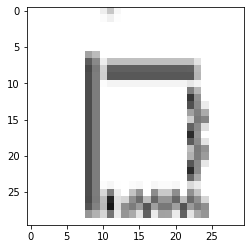

In [13]:
# test the loaded image data
index = 9

# to see index and image id
# for i, image_id in enumerate(X_train_df):
#     print(i,image_id)    

plt.imshow(X_train[index])
print(Y_train[index])

In [14]:
def CheckboxModel(input_shape):    
    
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
        
    # MAXPOOL
    X = MaxPooling2D((2, 2), name ='max_pool1')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates the Keras model instance, I'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='CheckboxModel')    
       
    return model

In [15]:
checkboxModel = CheckboxModel((height, width, 4))

W1223 15:48:30.218142 19200 deprecation_wrapper.py:119] From C:\Users\Hassan\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1223 15:48:30.770498 19200 deprecation_wrapper.py:119] From C:\Users\Hassan\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1223 15:48:31.095981 19200 deprecation_wrapper.py:119] From C:\Users\Hassan\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1223 15:48:31.920072 19200 deprecation_wrapper.py:119] From C:\Users\Hassan\Anaconda3\envs\deeplearning\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defaul

In [16]:
checkboxModel.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

W1223 15:49:46.498580 19200 deprecation_wrapper.py:119] From C:\Users\Hassan\Anaconda3\envs\deeplearning\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1223 15:49:46.746282 19200 deprecation.py:323] From C:\Users\Hassan\Anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
# Note that if you run fit() again, the model will continue to train with the parameters it has already learnt instead of reinitializing them.
history = checkboxModel.fit(x = X_train, y = Y_train, epochs = 30, batch_size = 16)

Epoch 1/30
1070/1070 [==============================] - 26s 25ms/step - loss: 0.6185 - acc: 0.7187
Epoch 2/30
1070/1070 [==============================] - 10s 10ms/step - loss: 0.4382 - acc: 0.7916
Epoch 3/30
1070/1070 [==============================] - 11s 10ms/step - loss: 0.4035 - acc: 0.8178
Epoch 4/30
1070/1070 [==============================] - 10s 10ms/step - loss: 0.3146 - acc: 0.8757
Epoch 5/30
1070/1070 [==============================] - 9s 9ms/step - loss: 0.2502 - acc: 0.8981A: 3s - loss: 0.2525 - acc: 0.899 - ETA: 3s 
Epoch 6/30
1070/1070 [==============================] - 10s 9ms/step - loss: 0.2447 - acc: 0.9019
Epoch 7/30
1070/1070 [==============================] - 9s 9ms/step - loss: 0.2079 - acc: 0.9299
Epoch 8/30
1070/1070 [==============================] - 10s 9ms/step - loss: 0.1743 - acc: 0.9411
Epoch 9/30
1070/1070 [==============================] - 9s 9ms/step - loss: 0.1775 - acc: 0.9327
Epoch 10/30
1070/1070 [==============================] - 11s 10ms/step - 

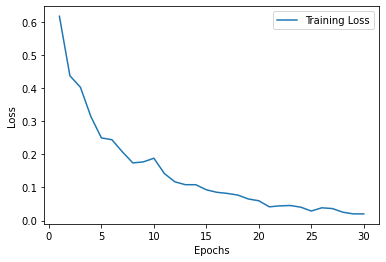

In [18]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
# prediction : apply model on the test data
preds = checkboxModel.evaluate(x = X_test, y = Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

357/357 [==============================] - 3s 9ms/step

Loss = 0.13251114941491676
Test Accuracy = 0.9635854341736695


[[0.]]


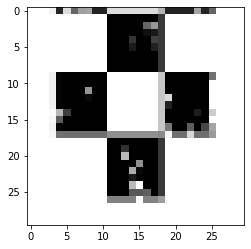

In [22]:
# feel free to test the model with an image

imgage_path = "D:/Hassan/data/checkbox-data/dataset-mleng-exercise/test_image/checkbox-02.not-checkbox.png"

img = image.load_img(imgage_path, target_size=(height, width, 4))
imshow(img)

if img.mode == "RGB":
    # print("rgb")
    a_channel = Image.new('L', img.size, 128)   # 'L' 8-bit pixels, black and white
    img.putalpha(a_channel)
      
x = image.img_to_array(img)
# print(x.shape)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(checkboxModel.predict(x))

# Model 2: Binary classification for checked/open

Input: a checkbox image

Output:

    1: checked

    0: open

In [23]:
# extract checkbox images
df_box = df[df['is_checkbox'] == 1]
print(df_box.shape)
df_box.sample(3)
#df['checked'].unique()

(1000, 6)


,path,image_id,name,label,is_checkbox,checked
417,D:/Hassan/Data Analysis/Interview/Scienceclini...,977,checkbox-03.checked.png,checked,1,1
772,D:/Hassan/Data Analysis/Interview/Scienceclini...,1332,checkbox-03.open.png,open,1,0
31,D:/Hassan/Data Analysis/Interview/Scienceclini...,32,checkbox-02.open.png,open,1,0


In [24]:
# Split the data into training and test sets
X = df_box['image_id']
y= df_box['checked']

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X,y, random_state=0) 

print ("number of training images = " + str(X_train_df.shape))
print ("number of test images = " + str(X_test_df.shape))
print ("Y_train shape: " + str(y_train_df.shape))
print ("Y_test shape: " + str(y_test_df.shape))



number of training images = (750,)
number of test images = (250,)
Y_train shape: (750,)
Y_test shape: (250,)


In [25]:
work_dir = "D:/Hassan/data/checkbox-data/dataset-mleng-exercise/images/"
height = 30
width = 30

#img = np.array(Image.open(work_dir + '1.png').resize((50,50)))

X_train = np.array([np.array(Image.open(work_dir + image_id + '.png').resize((height, width))) for image_id in X_train_df])
Y_train = y_train_df.to_numpy().reshape(( len(y_train_df), 1)) 

X_test = np.array([np.array(Image.open(work_dir + image_id + '.png').resize((height, width))) for image_id in X_test_df])
Y_test = y_test_df.to_numpy().reshape(( len(y_test_df), 1)) 

# Normalize image vectors
X_train = X_train/255.
X_test = X_test/255.

print ("number of training images = " + str(X_train.shape[0]))
print ("number of test images = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

assert(X_train.shape == (750,height,width,4))


number of training images = 750
number of test images = 250
X_train shape: (750, 30, 30, 4)
Y_train shape: (750, 1)
X_test shape: (250, 30, 30, 4)
Y_test shape: (250, 1)


[1]


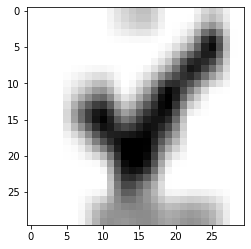

In [26]:
# test the loaded image data 
index = 500

# to see index and image id
# for i, image_id in enumerate(X_train_df):
#     print(i,image_id)    

plt.imshow(X_train[index])
print(Y_train[index])

In [27]:
def CheckboxStatusModel(input_shape):    
    
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
        
    # MAXPOOL
    X = MaxPooling2D((2, 2), name ='max_pool1')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates the Keras model instance, I'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='CheckboxStatusModel')    
       
    return model

In [28]:
checkbox_status = CheckboxStatusModel((height, width, 4))

In [29]:
checkbox_status.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [30]:
checkbox_status.fit(x = X_train, y = Y_train, epochs = 30, batch_size = 16)

Epoch 1/30
750/750 [==============================] - 15s 20ms/step - loss: 0.5655 - acc: 0.7160
Epoch 2/30
750/750 [==============================] - 6s 7ms/step - loss: 0.3672 - acc: 0.8560
Epoch 3/30
750/750 [==============================] - 5s 7ms/step - loss: 0.2915 - acc: 0.8653
Epoch 4/30
750/750 [==============================] - 5s 7ms/step - loss: 0.2299 - acc: 0.9067
Epoch 5/30
750/750 [==============================] - 5s 6ms/step - loss: 0.2224 - acc: 0.9107
Epoch 6/30
750/750 [==============================] - 5s 6ms/step - loss: 0.1677 - acc: 0.9413A: 3s - loss: 0.1967 - acc - ETA: 2s - lo
Epoch 7/30
750/750 [==============================] - 5s 6ms/step - loss: 0.1708 - acc: 0.9307
Epoch 8/30
750/750 [==============================] - 5s 6ms/step - loss: 0.1050 - acc: 0.9680
Epoch 9/30
750/750 [==============================] - 5s 7ms/step - loss: 0.0988 - acc: 0.9653A: 2s - loss:
Epoch 10/30
750/750 [==============================] - 5s 7ms/step - loss: 0.0744 - acc: 

In [31]:
# prediction : apply model on the test data
preds = checkbox_status.evaluate(x = X_test, y = Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

250/250 [==============================] - 3s 12ms/step

Loss = 0.16800924563407899
Test Accuracy = 0.9600000004768372


[[1.]]


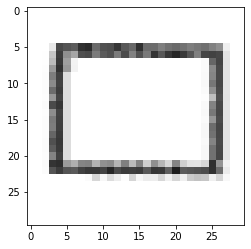

In [33]:
# feel free to test the model with an image

imgage_path = "D:/Hassan/data/checkbox-data/dataset-mleng-exercise/test_image/46.png"

img = image.load_img(imgage_path, target_size=(height, width, 4))
imshow(img)

if img.mode == "RGB":
    # print("rgb")
    a_channel = Image.new('L', img.size, 128)   # 'L' 8-bit pixels, black and white
    img.putalpha(a_channel)
      
x = image.img_to_array(img)
# print(x.shape)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(checkbox_status.predict(x))

# TBD for Improvement:

- applying image data augmentation and resolving imbalanced issue
- add regularization
- more preprocessing, e.g removing alpha channel, Dilation, Erosion 
- tune parameters
- change the CNN architecture, ResNet



# IDEA: looking into the text and image together
I think the text around a checkbox is usefull to recognize the box. 
so, running two nets (CNN and RNN) parallely can increase the certainty of the detection.
